<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/WaveletDenoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wavelet Transforms, Denoising, and Compression

Recall that with wavelet-based analysis, the time-frequency resolution is progressively altered from high- to low-frequencies such that a single wavelet shape is is being dilated to analyze the signal at various "scales". This is as if a filterbank is used to analyze the signal where the sharpness (i.e., quality factor, or the ratio between center-frequency and bandwidth) is constant.

![Tiling for wavelets](wavelettiling.png)

This allows for interesting denoising applications where different frequencies could be removed in different time windows (as opposed to conventional frequency-filtering where the same frequencies are suppressed throughout). This also allows for compression applications because many natural signals and images are sparse in the wavelet domain -- the number of large coefficients is small compared to the total number of coefficients.

In [1]:
import numpy as np
import pylab as pl

# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.33]
plt.rcParams['figure.dpi']  = 120

## EKG example

In [2]:
from scipy import io

dat = io.loadmat('ecg.mat', squeeze_me=True)

In [3]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ecg', 'fs'])

Text(0, 0.5, 'EKG')

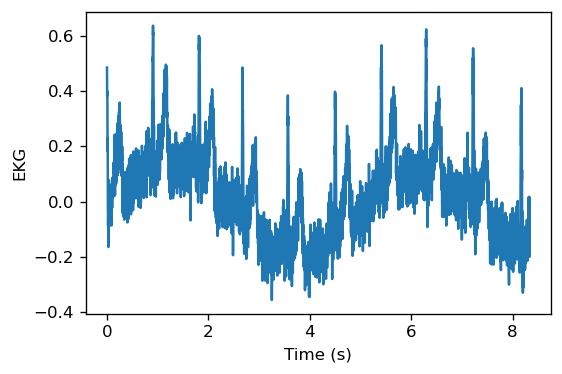

In [4]:
t = np.arange(0, dat['ecg'].shape[0]) / dat['fs']
pl.plot(t, dat['ecg'])
pl.xlabel('Time (s)')
pl.ylabel('EKG')

Text(0, 0.5, 'EKG')

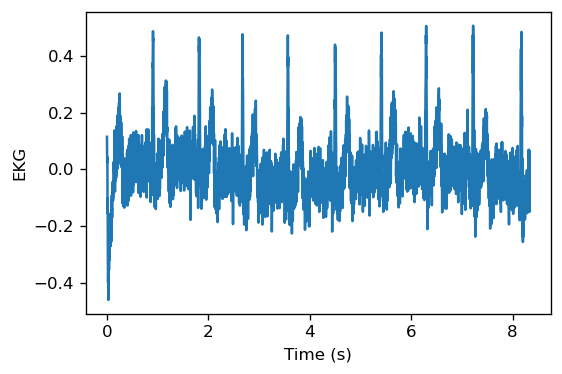

In [5]:
from scipy import signal
order = 255
f_high = 1
h = signal.firwin(order, f_high, pass_zero='highpass', fs=dat['fs'])
x = signal.filtfilt(h, 1, dat['ecg'])
pl.plot(t, x)
pl.xlabel('Time (s)')
pl.ylabel('EKG')

## Exploring discrete wavelet transforms

In [6]:
import pywt
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


### Examples from different continuous & discrete wavelet families

Text(0.5, 1.0, 'Mexican Hat')

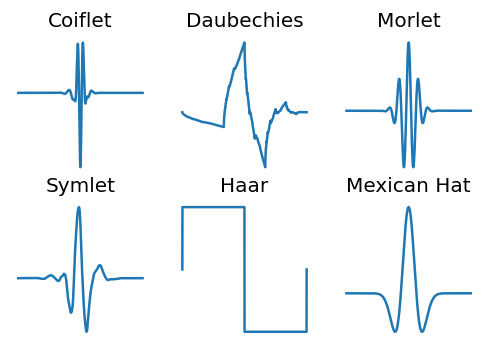

In [7]:
pl.subplot(2, 3, 1)
phi, psi, tau = pywt.Wavelet('coif5').wavefun(level=10)
pl.plot(tau, psi)
pl.axis('off')
pl.title('Coiflet')
pl.subplot(2, 3, 2)
phi, psi, tau = pywt.Wavelet('db2').wavefun(level=10)
pl.plot(tau, psi)
pl.axis('off')
pl.title('Daubechies')
pl.subplot(2, 3, 3)
psi, tau = pywt.ContinuousWavelet('morl').wavefun(level=10)
pl.plot(tau, psi)
pl.axis('off')
pl.title('Morlet')
pl.subplot(2, 3, 4)
phi, psi, tau = pywt.Wavelet('sym5').wavefun(level=10)
pl.plot(tau, psi)
pl.axis('off')
pl.title('Symlet')
pl.subplot(2, 3, 5)
phi, psi, tau = pywt.Wavelet('haar').wavefun(level=10)
pl.plot(tau, psi)
pl.axis('off')
pl.title('Haar')
pl.subplot(2, 3, 6)
psi, tau = pywt.ContinuousWavelet('mexh').wavefun(level=10)
pl.plot(tau, psi)
pl.axis('off')
pl.title('Mexican Hat')

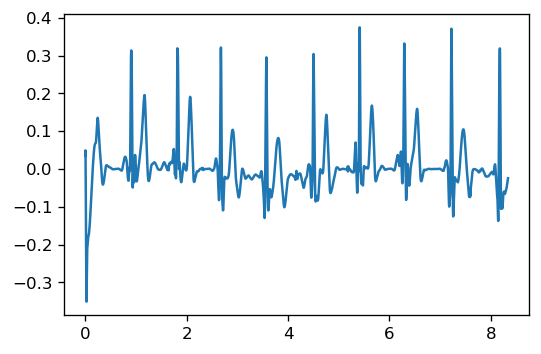

In [8]:
coeffs = pywt.wavedec(x,wavelet='coif3', level=5)

# Convert to array -- easier for thresholding
arr, slices = pywt.coeffs_to_array(coeffs)
thresh = 0.15
arr[abs(arr) < thresh] = 0
arr[arr > thresh] -= thresh
arr[arr < -thresh] += thresh

# Convert back to wavedec/waverec format
coeffs_denoised = pywt.array_to_coeffs(arr, slices, output_format='wavedec')
recon_denoised = pywt.waverec(coeffs_denoised, wavelet='coif3')
pl.plot(t, recon_denoised)

Text(0, 0.5, 'EKG')

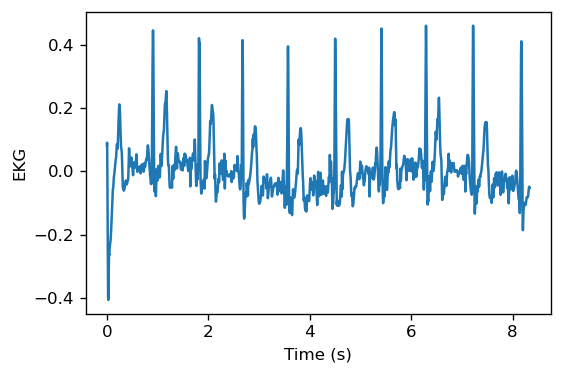

In [9]:
from skimage.restoration import denoise_wavelet
y = denoise_wavelet(x, wavelet='coif3')
pl.plot(t, y)
pl.xlabel('Time (s)')
pl.ylabel('EKG')

## Compression -- Speech Example

In [10]:
dat = io.loadmat('whitesilk.mat', squeeze_me=True)

In [11]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'fs', 'x'])

In [12]:
from IPython.display import Audio
Audio(data=dat['x'], rate=dat['fs'])

In [13]:
coeffs = pywt.wavedec(dat['x'],wavelet='coif3', level=5)

# Convert to array -- easier for thresholding
arr, slices = pywt.coeffs_to_array(coeffs)
ncoeffs = arr.shape[0]

thresh = 0.002
arr[abs(arr) < thresh] = 0
arr[arr > thresh] -= thresh
arr[arr < -thresh] += thresh
ncoeffs_compressed = (abs(arr) > thresh).sum()

# Convert back to wavedec/waverec format
coeffs_compressed = pywt.array_to_coeffs(arr, slices, output_format='wavedec')
compressed = pywt.waverec(coeffs_compressed, wavelet='coif3')
Audio(data=compressed, rate=dat['fs'])

In [14]:
print(f'Compressed size = {ncoeffs_compressed * 100./ ncoeffs: .1f}% of original size')

Compressed size =  13.0% of original size


## Compression -- Image Example

Text(0.5, 1.0, 'Original')

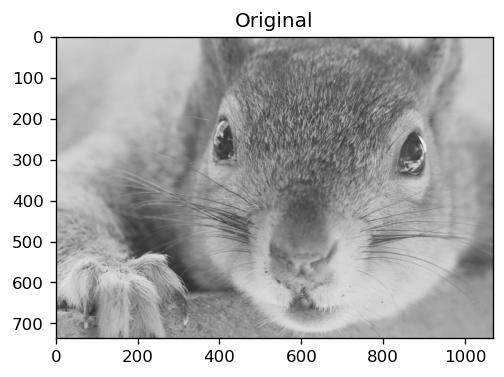

In [15]:
import imageio
J = imageio.imread('squirrel.png', as_gray=True)
J = np.float64(J)/255.
pl.imshow(J, cmap='gray', vmin=0, vmax=1)
pl.title('Original')

Compressed size =  3.4% of original size


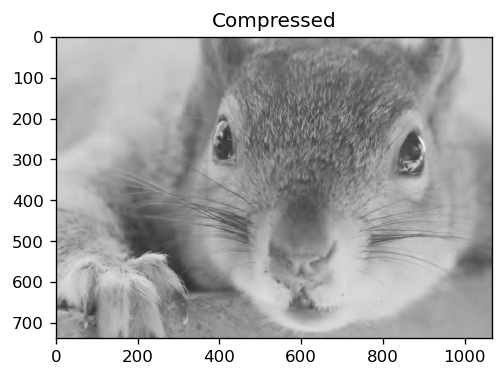

In [16]:
coeffs = pywt.wavedec2(J, wavelet='db2', level=6)


# Convert to array -- easier for thresholding
arr, slices = pywt.coeffs_to_array(coeffs)
ncoeffs = (abs(arr) > 0).sum()

thresh = 0.05
arr[abs(arr) < thresh] = 0
arr[arr > thresh] -= thresh
arr[arr < -thresh] += thresh
ncoeffs_compressed = (abs(arr) > thresh).sum()

# Convert back to wavedec/waverec format
coeffs_compressed = pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
compressed = pywt.waverec2(coeffs_compressed, wavelet='db2')
pl.imshow(compressed, cmap='gray', vmin=0, vmax=1)
pl.title('Compressed')
print(f'Compressed size = {ncoeffs_compressed * 100./ ncoeffs: .1f}% of original size')